## Access Vessel Satellite Radiance data in Zarr
A jupyter notebook to show how to access and plot the AODN vessel_satellite_radiance_delayed_qc dataset available as [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/28f8bfed-ca6a-472a-84e4-42563ce4df3f).

📌 The point of truth for this notebook is [on GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/vessel_satellite_radiance_delayed_qc.ipynb).

In [13]:
dataset_name = "vessel_satellite_radiance_delayed_qc"

## Install/Update packages and Load common functions

In [14]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.11 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Using Python 3.12.11 environment at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised
Audited 256 packages in 21ms


✅ Local version 0.2.4 is up to date (remote: 0.2.4)


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:2991: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


In [15]:
from DataQuery import GetAodn

# Understanding the Dataset

In [24]:
# remote zarr dataset
aodn = GetAodn()
dname = f'{dataset_name}.zarr'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 66.4 ms, sys: 12.4 ms, total: 78.8 ms
Wall time: 599 ms


In [25]:
ds = aodn_dataset.zarr_store
ds.info()

xarray.Dataset {
dimensions:
	WAVELENGTH_Ed = 200 ;
	TIME = 17526 ;
	WAVELENGTH_Lsky = 200 ;
	WAVELENGTH_Lu = 200 ;

variables:
	float64 Ed(WAVELENGTH_Ed, TIME) ;
		Ed:ancillary_variables = LATITUDE LONGITUDE relaz sza pitch pitchsd roll rollsd gearpos Ed_quality_control ;
		Ed:cell_method = LATITUDE: LONGITUDE: TIME: point ;
		Ed:long_name = Surface Downwelling Irradiance in air ;
		Ed:standard_name = surface_downwelling_spectral_radiative_flux_in_air ;
		Ed:units = W m^-2 nm^-1 ;
		Ed:valid_max = 10.0 ;
		Ed:valid_min = 0.0 ;
	int32 Ed_quality_control(WAVELENGTH_Ed, TIME) ;
		Ed_quality_control:flag_meanings = No_QC_was_performed Good_data Probably_good_data Bad_data_that_are_potentially_correctable Bad_data Value_changed Not_used Not_used Not_used Missing_value ;
		Ed_quality_control:flag_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ;
		Ed_quality_control:long_name = Surface Downwelling Irradiance Quality Control ;
		Ed_quality_control:quality_control_conventions = IMOS standard flags ;


## Plot time coverage

In [26]:
aodn_dataset.get_temporal_extent()

(Timestamp('2016-01-27 00:34:39.862063872'),
 Timestamp('2016-01-27 06:23:01.973392896'))

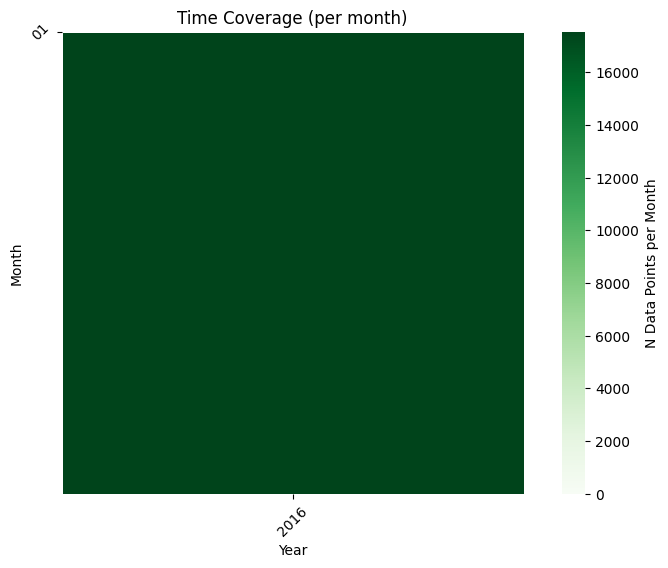

In [27]:
aodn_dataset.plot_time_coverage()

## Read Metadata

In [8]:
meta = aodn_dataset.get_metadata()

2025-08-14 11:52:40,120 - aodn.GetAodn - INFO - Retrieving metadata for s3://imos-data-lab-optimised/vessel_satellite_radiance_delayed_qc.zarr


## List unique vessels and filter data accordingly

In [9]:
import numpy as np
np.unique(ds.platform_code.data)

array(['', 'VLHJ', 'VMQ9273'], dtype='<U7')

In [10]:
%%time
ds = aodn_dataset.get_data(date_start='2012-06-09', date_end='2012-06-10', scalar_filter = {'platform_code' : 'VLHJ'})

CPU times: user 1.15 s, sys: 84.1 ms, total: 1.23 s
Wall time: 9.96 s


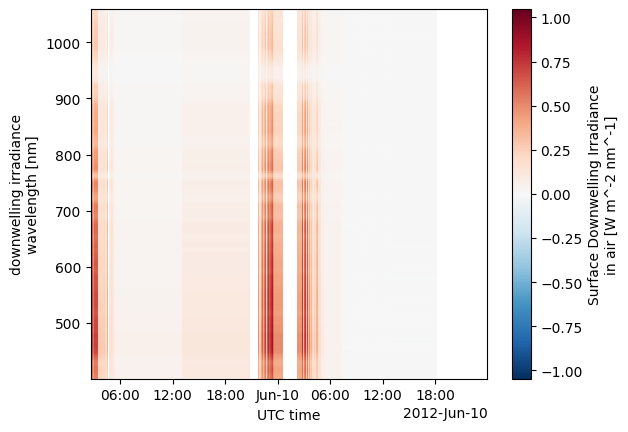

In [11]:
ds.Ed.plot()

In [28]:
ds = aodn_dataset.get_data(date_start='2016-01-24', date_end='2016-01-28', scalar_filter = {'platform_code' : 'VMQ9273'})

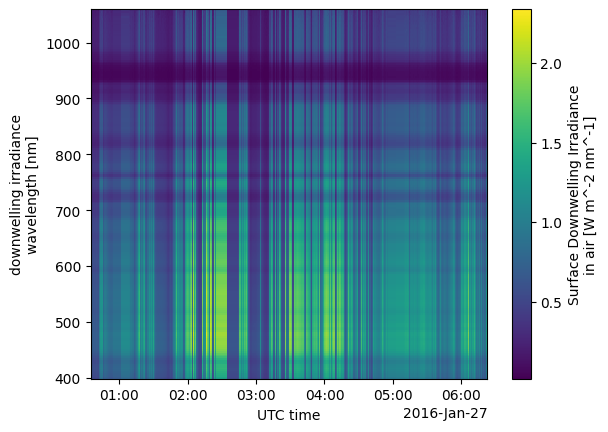

In [29]:
ds.Ed.plot()

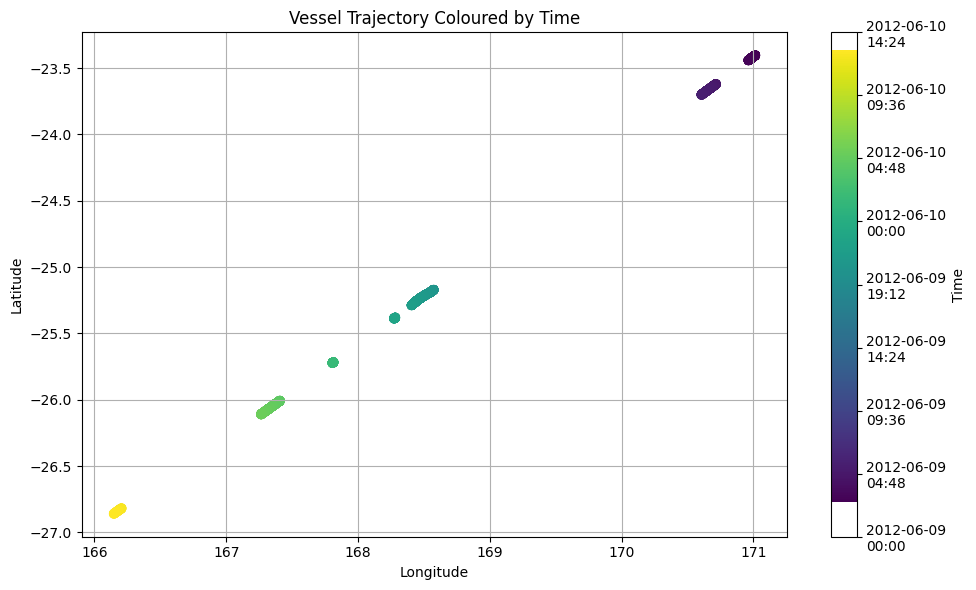

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

time = pd.to_datetime(ds["TIME"].values)
lat = ds["LATITUDE"].values
lon = ds["LONGITUDE"].values

# Convert times to matplotlib's numeric format
times_numeric = mdates.date2num(time)

fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(lon, lat, c=times_numeric, cmap='viridis', marker='o')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time')

tick_locs = cbar.get_ticks()
tick_labels = [mdates.num2date(t).strftime('%Y-%m-%d\n%H:%M') for t in tick_locs]
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

ax.set_title("Vessel Trajectory Coloured by Time")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
plt.tight_layout()
plt.show()
